# Analyze the Activations
In this notebook, we analyze the activations of the nueral network to determine how it might be functioning. To determine the activations we provided a set of inputs into the network and measure the inputs to each hidden layer. As these hidden layers cna have >$10^3$ inputs, we compute the first two principle components of the input features and only plot those. 


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import patheffects
from pymatgen import Element, Composition
from adjustText import adjust_text
import pandas as pd
import numpy as np
import os

Plotting details

In [2]:
font_size = 12
figure_width = 89 / 25.4
figure_height = figure_width

## Load in the Datasets
We have two different datasets: one of the activations of the elements, and the other of all possible AB compounds.

In [3]:
elem_dataset = pd.read_csv(os.path.join('activations', 'elem_act.csv'), index_col=0)

In [4]:
ab_dataset = pd.read_csv(os.path.join('activations', 'AB-set_act.csv'), index_col=0)

Make a utility function to get the activations for a certain layer

In [5]:
def get_activations(data, layer, add_columns=[]):
    return data[list(data.columns[:1]) + ['act_layer_{}_{}'.format(layer, x) for x in [0,1]] + add_columns]

In [6]:
to_plot = get_activations(elem_dataset, 1)

## Study the Element Activations
The main thing we are curious about is whether the network detects similarity between elements

In [7]:
elem_dataset['label'] = elem_dataset['group_id'].apply(lambda x: 'Group {}'.format(x))

Plot the first hidden layer

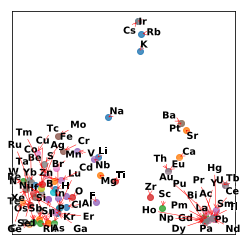

In [8]:
fig, ax = plt.subplots()
def make_layer_plot(ax, data, layer, color_by=['group_id'], label='label', autoarrange=True, lim=250):
    
    # Get the data to plot
    to_plot = get_activations(data, layer, color_by + [label]).copy()
    
    # Normalize the activations
    to_plot.loc[:,1:3] = (to_plot.values[:,1:3] - to_plot.values[:,1:3].min(axis=0)) /  \
        (to_plot.values[:,1:3].max(axis=0) - to_plot.values[:,1:3].min(axis=0))
    
    labels = []
    for label, group in to_plot.groupby(color_by):
        ax.scatter(group.values[:,1], group.values[:,2], label=group['label'].iloc[0], alpha=0.8)
        for l,x,y in group.values[:,:3]:
            labels.append(ax.text(x, y, l, ha='center', va='center', fontweight='bold', fontsize=font_size*0.8,
                                 bbox={'facecolor':'w', 'edgecolor':'none', 'alpha':0.2, 'boxstyle':"square,pad=0."},
                                 path_effects=[patheffects.SimpleLineShadow(), patheffects.Normal()]))
            
    # Format the axis
    ax.set_xlim([-0.05,1.05])
    ax.set_ylim([-0.05,1.05])
    ax.set_xticks([])
    ax.set_yticks([])
    
    #ax.set_xlabel('PC1')
    #ax.set_ylabel('PC2')
    
    if autoarrange:
        adjust_text(labels, ax=ax, arrowprops=dict(arrowstyle="->", color='r', lw=0.5), lim=lim)
            
make_layer_plot(ax, elem_dataset, 1)

fig.set_size_inches(figure_width, figure_height)
fig.tight_layout()

*Finding*: This is a little bit messy. Let's just plot the main group elements

In [9]:
acceptable_groups = [1, 2, 13, 14, 15, 16, 17]

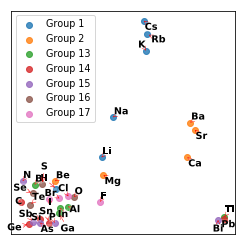

In [10]:
fig, ax = plt.subplots()
            
make_layer_plot(ax, elem_dataset[[e in acceptable_groups for e in elem_dataset['group_id']]], 1)

ax.legend(fontsize=font_size*0.8, loc='upper left')

fig.set_size_inches(figure_width, figure_height)
fig.tight_layout()

*Findings*: 
- Element groups are only similar arcs, and ordered by the row
- Metalloids/nonmetals are separate from metals in the same group (see Pb)

Plot some later layers

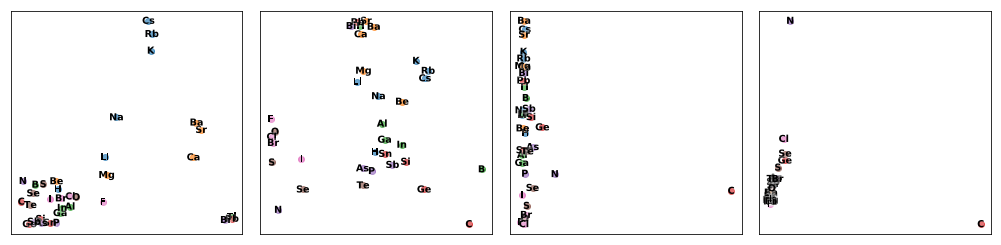

In [11]:
fig, axs = plt.subplots(1, 4)
            
for i,ax in enumerate(axs):
    make_layer_plot(ax, elem_dataset[[e in acceptable_groups for e in elem_dataset['group_id']]], i+1, autoarrange=False)

fig.set_size_inches(figure_width * 4, figure_height)
fig.tight_layout()

*Finding*: As we increase the number of layers, the "periodic-table-ness" starts to disappear

## Analyze the Binary Compounds
Our hypothesis is that the later layers encode the interactions between elements

### Load in more compound data
Join the AB projections with some other data about each compound

In [12]:
ab_metadata = pd.read_csv(os.path.join('datasets', 'AB-set.csv'))

In [13]:
ab_dataset = ab_dataset.merge(ab_metadata, on='pretty_comp')
ab_dataset = ab_dataset[~ab_dataset['pretty_comp'].isnull()]

### Plot based on formation enthalpy
The network should at least group AB compounds with similar formation enthalpies

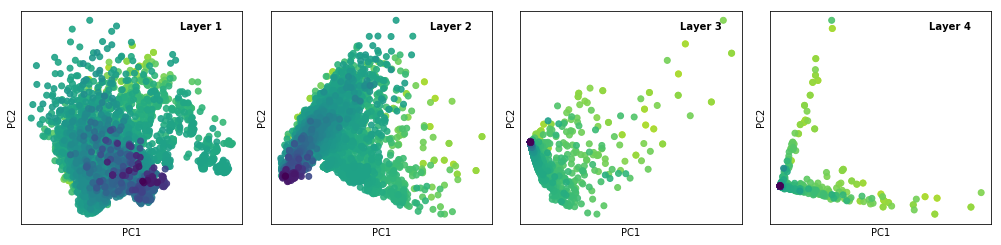

In [14]:
fig, axs = plt.subplots(1, 4)
def make_value_layer_plot(ax, data, layer, value='delta_e', ascending=False):
     # Get the data to plot
    to_plot = get_activations(data, layer, [value]).copy()
    
    # Normalize the activations
    to_plot.loc[:,1:3] = (to_plot.values[:,1:3] - to_plot.values[:,1:3].min(axis=0)) /  \
        (to_plot.values[:,1:3].max(axis=0) - to_plot.values[:,1:3].min(axis=0))
    
    to_plot.sort_values(value, ascending=ascending, inplace=True)
    cb_data = ax.scatter(to_plot.values[:,1], to_plot.values[:,2], c=to_plot[value], alpha=0.9)
                
    # Format the axis
    ax.set_xlim([-0.05,1.05])
    ax.set_ylim([-0.05,1.05])
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

for i,ax in enumerate(axs):
    make_value_layer_plot(ax, ab_dataset, i+1, 'delta_e')
    ax.text(0.95, 0.95, 'Layer {}'.format(i+1), ha='right',
           fontweight='bold')
    
fig.set_size_inches(figure_width * 4, figure_height)
fig.tight_layout()

*Finding*: As we increase the layers, the large formation enthalpy etries are clustered together. This is expected behavior for NNs

## Understand the element clustering
The above plots of formation enthalpy being cluster do not tell us much about what kind of features it is learning.

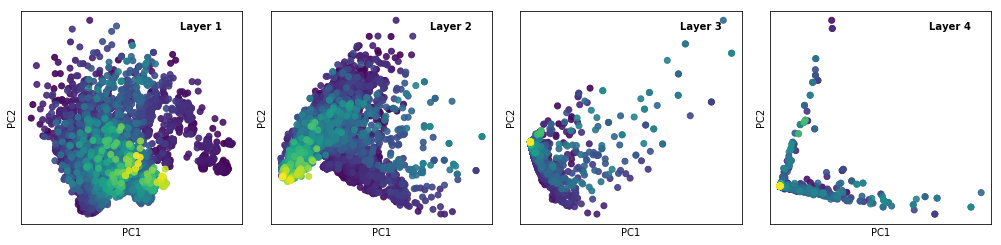

In [15]:
fig, axs = plt.subplots(1, 4)
for i,ax in enumerate(axs):
    make_value_layer_plot(ax, ab_dataset, i+1, 'range X', ascending=True)
    ax.text(0.95, 0.95, 'Layer {}'.format(i+1), ha='right',
           fontweight='bold')
    
fig.set_size_inches(figure_width * 4, figure_height)
fig.tight_layout()

*Finding*: We also see compounds with larger differencs in electronegativity being grouped together, but that is because this is related to formation enthalpy.

To understand the grouping of elements better, let us consider a subset of AB compounds. Those with a group 1 or 2 cation and either P, S, or Cl as the anion.

In [16]:
ab_dataset['comp_obj'] = ab_dataset['pretty_comp'].apply(lambda x: Composition(x))

In [17]:
def has_elements(c, elems):
    return any([Element(e) in c.keys() for e in elems])
has_anions = ab_dataset['comp_obj'].apply(lambda x: has_elements(x, ['S', 'Cl']))

In [38]:
has_cations = ab_dataset['comp_obj'].apply(lambda x: has_elements(x, ['Li', 'Na', 'K', 'Rb', 'Cs'] +
                                                                 ['Mg', 'Ca', 'Sr', 'Ba']))

In [39]:
ab_subset = ab_dataset[np.logical_and(has_anions, has_cations)].copy()

In [40]:
ab_subset['anion_group'] = ab_subset['comp_obj'].apply(lambda x: max([e.group for e in x]))

In [41]:
ab_subset['cation_group'] = ab_subset['comp_obj'].apply(lambda x: min([e.group for e in x]))

In [42]:
ab_subset['label'] = ab_subset.apply(lambda x: '{1}-{0}'.format('VI' if x['anion_group'] == 17 else 'V',
                                                             'I' if x['cation_group'] == 1 else 'II'), axis=1)

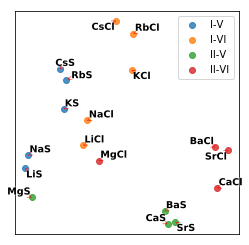

In [43]:
fig, ax = plt.subplots()

make_layer_plot(ax, ab_subset, 1, color_by=['label'], label='anion_group', autoarrange=True)

fig.set_size_inches(figure_width, figure_height)

ax.legend()

fig.tight_layout()

*Finding*: Somewhat unsurprsing result. Different combinations of elements are cluster together. I-V is closer to I-VI than II-VI

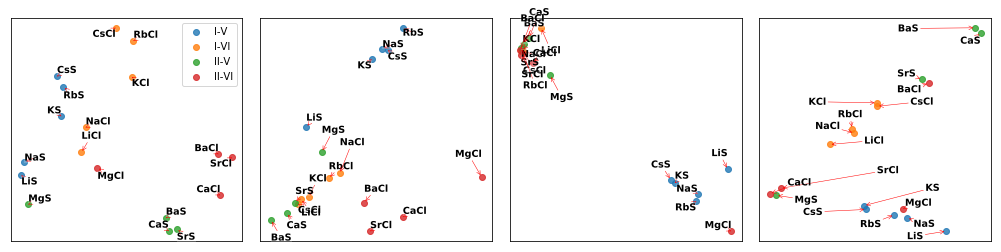

In [44]:
fig, axs = plt.subplots(1, 4)
            
for i,ax in enumerate(axs):
    make_layer_plot(ax, ab_subset, 1+i, color_by=['label'], label='anion_group', autoarrange=True)

axs[0].legend()
fig.set_size_inches(figure_width * 4, figure_height)
fig.tight_layout()

*Findings*:
- In the first layer, element groups are closest based on similarity between the groups:
    - I-V is closer to I-VI than II-VI
    - II-V is closer to II-V than I-VI
    - Ca-Cl is closer to Cs-S than the Alkali Metal Chlorides
- In the second layer, charge-balanced compounds are closer together than elements that simply have similar elements

## Make a Figure
Combine these figures together into a plot for the paper

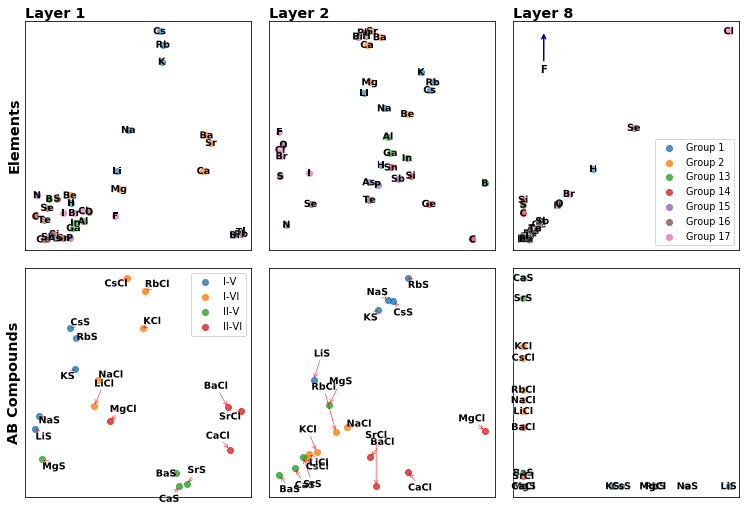

In [45]:
fig, axs = plt.subplots(2, 3)

layers=[1,2,8]
elem_subset = elem_dataset[[e in acceptable_groups for e in elem_dataset['group_id']]]
for i,ax in zip(layers, axs[0,:]):
    if i != 8:
        make_layer_plot(ax, elem_subset, i, autoarrange=False)
    else:
        to_plot = elem_subset.query('element != "F"')
        make_layer_plot(ax, to_plot, i, autoarrange=False)
        ax.annotate('F', xy=(0.1, 1), xytext=(0.1, 0.8), transform=ax.transAxes,
                    ha='center', arrowprops=dict(arrowstyle="->", color='darkblue', lw=1.5),
                   fontweight='bold')

for i,ax in zip(layers, axs[1,:]):
    make_layer_plot(ax, ab_subset, i, color_by=['label'], label='anion_group', autoarrange=True if i != 8 else False, lim=1000)

for ax, l in zip(axs[0, :], layers):
    ax.text(0, 1, 'Layer {}'.format(l), ha='left', va='bottom',
            fontweight='bold', fontsize=font_size*1.2, transform=ax.transAxes)

axs[0, 2].legend(ncol=1, loc='lower right', fontsize=font_size*0.8)
axs[1, 0].legend()

axs[0, 0].set_ylabel('Elements', fontsize=font_size*1.2, fontweight='bold')
axs[1, 0].set_ylabel('AB Compounds', fontsize=font_size*1.2, fontweight='bold')

fig.set_size_inches(figure_width * 3, figure_height * 2)
fig.tight_layout()

fig.savefig(os.path.join('figures', 'layer-projection.png'), dpi=320)
fig.savefig(os.path.join('figures', 'layer-projection.pdf'))